In [ ]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 62.1MB/s]


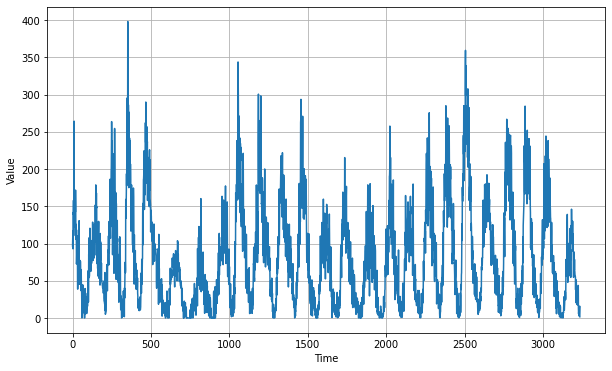

In [4]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

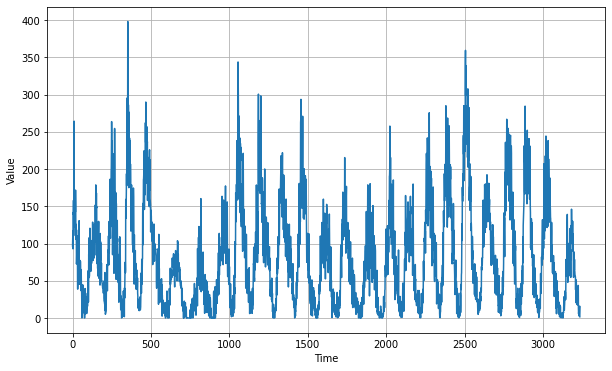

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),

  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),

  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


12/12 [==============================] - 1s 61ms/step - loss: 52.7529 - mae: 53.2506 - lr: 3.1623e-04
Epoch 92/100
12/12 [==============================] - 1s 62ms/step - loss: 66.0973 - mae: 66.5962 - lr: 3.5481e-04
Epoch 93/100
12/12 [==============================] - 1s 62ms/step - loss: 57.4962 - mae: 57.9943 - lr: 3.9811e-04
Epoch 94/100
12/12 [==============================] - 1s 61ms/step - loss: 55.7778 - mae: 56.2760 - lr: 4.4668e-04
Epoch 95/100
12/12 [==============================] - 1s 63ms/step - loss: 54.8863 - mae: 55.3845 - lr: 5.0119e-04
Epoch 96/100
12/12 [==============================] - 1s 61ms/step - loss: 75.7522 - mae: 76.2507 - lr: 5.6234e-04
Epoch 97/100
12/12 [==============================] - 1s 60ms/step - loss: 62.9138 - mae: 63.4120 - lr: 6.3096e-04
Epoch 98/100
12/12 [==============================] - 1s 61ms/step - loss: 57.8493 - mae: 58.3477 - lr: 7.0795e-04
Epoch 99/100
12/12 [==============================] - 1s 61ms/step - loss: 54.1858 - mae: 54.

(1e-08, 0.0001, 0.0, 60.0)

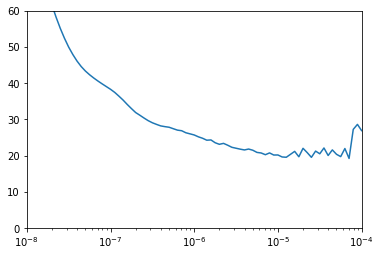

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)   # Our numbers are in the 1 - 400 range. So, lambda layer multiplies our x by 400.
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

30/30 [==============================] - 2s 43ms/step - loss: 14.6138 - mae: 15.0995
Epoch 491/500
30/30 [==============================] - 2s 42ms/step - loss: 14.4512 - mae: 14.9369
Epoch 492/500
30/30 [==============================] - 1s 41ms/step - loss: 14.5185 - mae: 15.0043
Epoch 493/500
30/30 [==============================] - 2s 42ms/step - loss: 14.4891 - mae: 14.9747
Epoch 494/500
30/30 [==============================] - 2s 43ms/step - loss: 14.5670 - mae: 15.0532
Epoch 495/500
30/30 [==============================] - 2s 42ms/step - loss: 14.5537 - mae: 15.0395
Epoch 496/500
30/30 [==============================] - 1s 39ms/step - loss: 14.4702 - mae: 14.9560
Epoch 497/500
30/30 [==============================] - 1s 41ms/step - loss: 14.5754 - mae: 15.0616
Epoch 498/500
30/30 [==============================] - 1s 41ms/step - loss: 14.6937 - mae: 15.1801
Epoch 499/500
30/30 [==============================] - 1s 40ms/step - loss: 14.5293 - mae: 15.0153
Epoch 500/500
30/30 [===

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

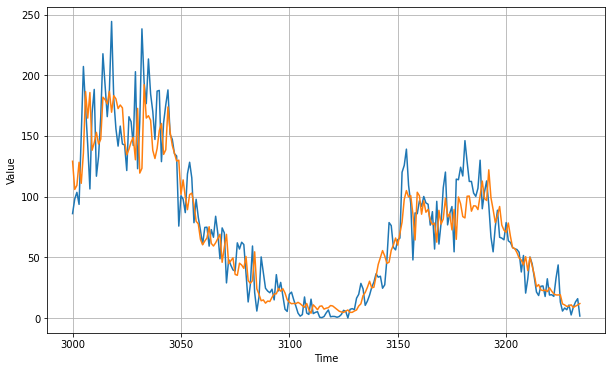

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.728472

<Figure size 432x288 with 0 Axes>

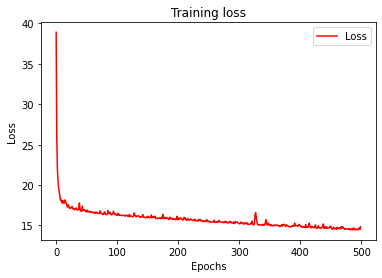

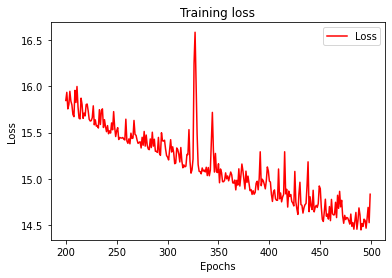

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[129.1308    105.90159   109.26397   128.2731    110.94246   135.86745
 186.52997   164.66205   185.73349   138.16702   144.31984   152.91396
 143.2457    147.34456   181.89359   179.9472    176.3271    186.71577
 169.5393    183.1831    180.51729   172.51187   175.46341   173.11038
 145.68173   134.43922   139.01799   145.0248    148.83206   130.34468
 172.69295   119.3761    123.31891   192.23248   164.71724   166.64404
 162.89635   138.16257   131.39284   139.6061    154.30492   160.21376
 134.77905   138.556     173.86798   153.25198   142.18263   135.89917
 129.29646   130.01022   101.86007   113.765976   99.74119    89.23
 101.65217   102.881744   93.45958    79.714516   77.49875    64.750565
  60.32363    63.386353   65.94682    75.169716   61.42437    59.290512
  61.93403    65.527695   68.96838    45.87431    58.265053   68.914734
  44.746357   47.15841    49.557888   35.871475   35.15613    45.14013
  43.631912   40.8908     50.660717   30.813038   28.598747   30.78999
  54.5